# **LT Toolbox Tutorial: 3. Advanced Analysis with Trajectory Frames**

Welcome to the Lagrangian Trajectories Toolbox tutorial! 

The LT Toolbox is a Python library dedicated to the post-processing, visualisation and analysis of Lagrangian water parcel trajectories. The toolbox offers users two structures for working with Lagrangian trajectories: Trajectory Arrays (TrajArrays) and Trajectory Frames (TrajFrames). In this tutorial, we continue exploring TrajFrames, which make use of [Polars](http://pola.rs) blazingly fast DataFrames to store column variables associated with trajectories (e.g. lat, lon, in-situ temperature etc.).

In this advanced tutorial, we will learn how to:

+ **Add** new attribute variables using the Polars expressions syntax to your TrajFrame.

+ **Compute** binned statistics, such as the Lagrangian probability, and grouped statistics, such as meridional heat transport, from Lagrangian trajectories.

+ **Map** probabilities and properties determined from Lagrangian trajectories.

To learn about the basics of working with TrajFrames, including simple filtering and using datetimes, users should see **LT Toolbox Tutorial: 2. Getting Started with Trajectory Frames**.


## Getting Started

Let us begin by importing the relevant packages we'll need to get started with the LT Toolbox. 

**Note**: Since lt_toolbox is still undergoing unit testing, the package is not yet available on PyPi, we use pip to install a local development version.

In [1]:
# Import relevant Python packages:
import xarray as xr
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

# Following pip installation as shown on the LT Toolbox github:
import lt_toolbox as ltt

### Storing Trajectory Data

To explore the functionality of the LT Toolbox, we will use example output from a Lagrangian particle tracking experiment using the eddy-rich ORCA0083-GO8p7 JRA55 ocean sea-ice hindcast ([Megann et al. 2022](https://dx.doi.org/10.5285/399b0f762a004657a411a9ea7203493a)). Trajectories were advected forwards-in-time from the full-depth northward inflows across the Overturning in the Subpolar North Atlantic (OSNAP) East array.

We have provided some example trajectory output for the January 1995 initialisation in the .parquet file format.

Below we load the output .parquet file as a DataFrame with Polars, before creating a TrajFrame, traj.

In [2]:
# Defining filepath to our example ORCA0083-GO8p7 output trajectory file:
traj_filepath = "/home/snapdragon/HadGEM3-GC31-MM/Proj_Future_Pathways/src/Software/lt_toolbox/docs/tutorials/data/ORCA0083-GO8p7_JRA55_SPNA_1995_example.parquet"

# Open output .parquet file as a DataFrame.
dataset = pl.read_parquet(traj_filepath, use_pyarrow=True)

# Create a TrajFrame from the DataFrame:
traj = ltt.TrajFrame(source=dataset, condense=True)

# Here we see how condensing a TrajFrame will store all observations in
# lists per trajectory (rows) instead of in a row per observation.
traj

<TrajFrame object>

----- Trajectory DataFrame -----
Trajectories: 2500
Variables: ['id', 'x', 'y', 'z', 'subvol', 'time', 'boxface', 'thetao', 'so', 'mask']
<bound method DataFrame.glimpse of shape: (2_500, 10)
┌───────┬────────────┬────────────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ id    ┆ x          ┆ y          ┆ z          ┆ … ┆ boxface   ┆ thetao    ┆ so        ┆ mask      │
│ ---   ┆ ---        ┆ ---        ┆ ---        ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ i64   ┆ list[f64]  ┆ list[f64]  ┆ list[f64]  ┆   ┆ list[i64] ┆ list[f64] ┆ list[f64] ┆ list[f64] │
╞═══════╪════════════╪════════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1     ┆ [3085.0,   ┆ [2888.5,   ┆ [46.5,     ┆ … ┆ [1, 4, …  ┆ [4.35,    ┆ [35.22,   ┆ [1.0,     │
│       ┆ 3085.0, …  ┆ 2888.0, …  ┆ 46.42, …   ┆   ┆ 4]        ┆ 4.34, …   ┆ 35.22, …  ┆ 1.0, …    │
│       ┆ 2840.83]   ┆ 2793.0]    ┆ 48.03]     ┆   ┆           ┆ 3.81]     ┆ 35.1

### Transforming x,y,z variables to lon,lat,depth in a TrajFrame.

In our example TrajFrame, we have stored the positions of each trajectory as indices referring to the original numerical model grid (eORCA12). However, we can easily transform these model coordinates to geographical coordinates using the **.transform_trajectory_coords()** method which uses bi-linear interpolation to determine each trajectories geographical position.

In [3]:
# Importing eORCA12 ocean model grid from a NetCDF file using xarray:
ds_grid = xr.open_dataset('/home/snapdragon/HadGEM3-GC31-MM/Proj_Future_Pathways/src/Software/lt_toolbox/docs/tutorials/data/ORCA0083-GO8p7_JRA55_model_grid.nc')

ds_grid

<xarray.Dataset> Size: 125MB
Dimensions:  (y: 3606, x: 4322, z: 75)
Dimensions without coordinates: y, x, z
Data variables:
    nav_lat  (y, x) float32 62MB ...
    nav_lon  (y, x) float32 62MB ...
    nav_lev  (z) float32 300B ...
Attributes:
    file_name:  mesh_mask.nc
    TimeStamp:  30/09/2016 08:33:26 +0000

In [4]:
# Transform the TrajFrame to geographical coordinates and store as new TrajFrame object:
traj_geo = traj.transform_trajectory_coords(lon=ds_grid.nav_lon.values,
                                            lat=ds_grid.nav_lat.values,
                                            depth=ds_grid.nav_lev.values,
                                            )

traj_geo

<TrajFrame object>

----- Trajectory DataFrame -----
Trajectories: 2500
Variables: ['id', 'lon', 'lat', 'depth', 'subvol', 'time', 'boxface', 'thetao', 'so', 'mask']
<bound method DataFrame.glimpse of shape: (2_500, 10)
┌───────┬────────────┬────────────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ id    ┆ lon        ┆ lat        ┆ depth      ┆ … ┆ boxface   ┆ thetao    ┆ so        ┆ mask      │
│ ---   ┆ ---        ┆ ---        ┆ ---        ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ i64   ┆ list[f64]  ┆ list[f64]  ┆ list[f64]  ┆   ┆ list[i64] ┆ list[f64] ┆ list[f64] ┆ list[f64] │
╞═══════╪════════════╪════════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1     ┆ [-30.38194 ┆ [58.799782 ┆ [1098.9227 ┆ … ┆ [1, 4, …  ┆ [4.35,    ┆ [35.22,   ┆ [1.0,     │
│       ┆ 3, -30.380 ┆ ,          ┆ 29, 1090.4 ┆   ┆ 4]        ┆ 4.34, …   ┆ 35.22, …  ┆ 1.0, …    │
│       ┆ 463, …     ┆ 58.774166, ┆ 31772, …   ┆   ┆           ┆ 3.81]   

### **Adding Attribute Variables with List Expressions**

Often when we want to add a new attribute variables to our TrajFrame, we would like to compute a complex function using existing attribute variables, for example potential density from temperature and salinity recorded along-stream. Below we show how we can do this using Polars expressions syntax and list operations.

In [5]:
# Import the density module from Gibbs Seawater Toolbox (gsw):
import gsw.density as density

# Compute potential density anomaly (sigma0) from conservative temperature
# and absolute salinity recorded along our trajectories:
traj_geo = traj_geo.add_variable(name='sigma0',
                                 expr=density.sigma0(CT=pl.col('thetao'), SA=pl.col('so')),
                                 list_expr=True,
                                 )

traj_geo

<TrajFrame object>

----- Trajectory DataFrame -----
Trajectories: 2500
Variables: ['id', 'lon', 'lat', 'depth', 'subvol', 'time', 'boxface', 'thetao', 'so', 'mask', 'sigma0']
<bound method DataFrame.glimpse of shape: (2_500, 11)
┌───────┬────────────┬────────────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ id    ┆ lon        ┆ lat        ┆ depth      ┆ … ┆ thetao    ┆ so        ┆ mask      ┆ sigma0    │
│ ---   ┆ ---        ┆ ---        ┆ ---        ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ i64   ┆ list[f64]  ┆ list[f64]  ┆ list[f64]  ┆   ┆ list[f64] ┆ list[f64] ┆ list[f64] ┆ list[f64] │
╞═══════╪════════════╪════════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1     ┆ [-30.38194 ┆ [58.799782 ┆ [1098.9227 ┆ … ┆ [4.35,    ┆ [35.22,   ┆ [1.0,     ┆ [27.79184 │
│       ┆ 3, -30.380 ┆ ,          ┆ 29, 1090.4 ┆   ┆ 4.34, …   ┆ 35.22, …  ┆ 1.0, …    ┆ 6, 27.792 │
│       ┆ 463, …     ┆ 58.774166, ┆ 31772, …   ┆   ┆ 3.81]     

### **Computing Grouped Expressions**

In addition to the more basic computations demonstrated in Tutorial 2, the LT-Toolbox also includes several more advanced computation methods which return n-dimensional arrays as outputs since they do not conform to the tabular structure of our Lagrangian trajectory data. To help manage the resulting n-dimensional arrays produced, a TrajFrame also stores these in an xarray DataSet accessible via the **summary_data** attribute.

Below we show a simple example of a grouped expression where we group over the water parcel ID variable in an uncondensed TrajFrame. Note, that this example is for illustrative purposes only since we could store this output in our condensed TrajFrame.

A more common example of grouped expressions is computing an aggregated statistic over groups of water parcel trajectories; for example, we could compute the average transit time grouped over start time if we had released parcels every month for a year.

In [6]:
# Create an uncondensed TrajFrame from our example DataFrame:
traj = ltt.TrajFrame(source=dataset)

# Define physical constants:
rho0 = 1025  # Reference seawater density in kg/m^3
Cp = 3992  # Seawater specific heat capacity in J/kg/K

# Define Polars expression to compute the change in heat
# transport of each water parcel trajectory:
expr = rho0*Cp*pl.col('subvol').first()*(pl.col('thetao').last() - pl.col('thetao').first())

# Computing the change in heat transport of each water parcel trajectory:
traj = traj.compute_grouped_expr(group='id', expr=expr, alias='dMHT', append=False)

# Display the summary data of the TrajFrame:
traj.summary_data

<xarray.Dataset> Size: 40kB
Dimensions:  (id: 2500)
Coordinates:
  * id       (id) int64 20kB 1 12 15 21 26 32 ... 28473 28512 28549 28956 28990
Data variables:
    dMHT     (id) float64 20kB -5.24e+08 -5.837e+09 ... -1.32e+10 -1.097e+10

### **Computing 1-dimensional Binned Statistics**

A further example of an advanced computation is to compute 1-dimensional binned statistics or histograms using the positions or properties sampled along water parcel trajectories. 

Below we demonstrate how to compute the sum of water parcel volume transport binned according to their initial longitude at the point of release along the Overturning in the Subpolar North Atlantic Program (OSNAP) array in the subpolar North Atlantic.

We will visualise our results with xarray's in-built plotting wrapper of the matplotlib library.

In [7]:
# Define discrete longitude bins:
bin_lon = np.arange(-33, 0, 1).tolist()

# Compute 1-D summed volume transport in discrete longitude bins:
traj_geo = (traj_geo
            # Add volume transport [Sv] per parcel as an attribute variable:
            .add_variable(name='subvol_ini',
                          expr=(pl.col('subvol').list.first() / 1E6),
                          list_expr=False,
                          )
            # Add the initial longitude of each parcel as an attribute variable:
            .add_variable(name='lon_ini',
                          expr=pl.col('lon').list.first(),
                          list_expr=False,
                          )
            # Compute volume transport in discrete longitude bins:
            .compute_binned_statistic_1d(var='lon_ini',
                                         values='subvol_ini',
                                         statistic='sum',
                                         bin_breaks=bin_lon,
                                         alias='subvol_x_ini',
                                         group=None, # No group-by required.
                                         append=True, # Allow append to existing summary DataSet.
                                         )
            )

# Display the summary data of the TrajFrame:
traj_geo.summary_data

<xarray.Dataset> Size: 368B
Dimensions:       (lon_ini: 23)
Coordinates:
  * lon_ini       (lon_ini) float64 184B -30.5 -29.5 -28.5 ... -10.5 -9.5 -8.5
Data variables:
    subvol_x_ini  (lon_ini) float64 184B 0.01537 0.8793 ... 0.02333 0.0009916

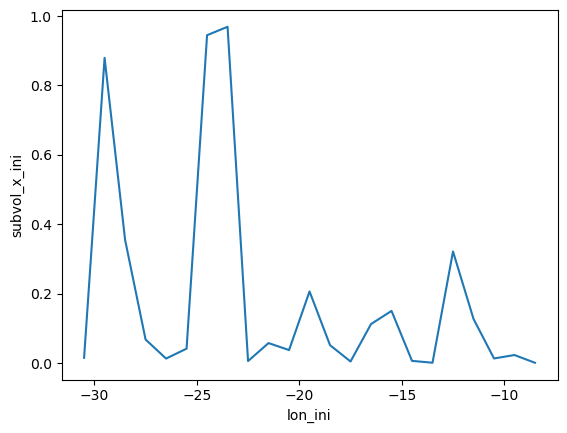

In [8]:
# Plotting the summed volume transport in discrete longitude bins:
traj_geo.summary_data.subvol_x_ini.plot()

### **Computing 2-dimensional Binned Statistics**

We next extend our computation to a 2-dimensional binned statistic using two different positions or properties sampled along water parcel trajectories. 

Below we demonstrate how to compute the average potential density recorded along-stream binned according to the longitude and latitude positions of our trajectories in the subpolar North Atlantic.

We will again visualise our results with xarray's in-built plotting wrapper of the matplotlib library.

In [9]:
# Define discrete depth bins:
bin_lon = np.arange(-70, 0, 0.25).tolist()
bin_lat = np.arange(50, 70, 0.25).tolist()

# Compute 2-D mean potential density in discrete longitude-latitude bins:
traj_geo = (traj_geo
            # Compute volume transport in discrete longitude-latitude bins:
            .compute_binned_statistic_2d(var_x='lat',
                                         var_y='lon',
                                         values='sigma0',
                                         statistic='mean',
                                         bin_breaks=[bin_lat, bin_lon],
                                         alias='sigma0_xy',
                                         group=None, # No group-by required!
                                         append=True, # Allow append to existing summary DataSet.
                                         )
            )

# Display the summary data of the TrajFrame:
traj_geo.summary_data

<xarray.Dataset> Size: 140kB
Dimensions:       (lon_ini: 23, lat: 69, lon: 248)
Coordinates:
  * lon_ini       (lon_ini) float64 184B -30.5 -29.5 -28.5 ... -10.5 -9.5 -8.5
  * lat           (lat) float64 552B 51.88 52.12 52.38 ... 68.38 68.62 68.88
  * lon           (lon) float64 2kB -66.88 -66.62 -66.38 ... -5.375 -5.125
Data variables:
    subvol_x_ini  (lon_ini) float64 184B 0.01537 0.8793 ... 0.02333 0.0009916
    sigma0_xy     (lat, lon) float64 137kB nan nan nan nan ... nan nan nan nan

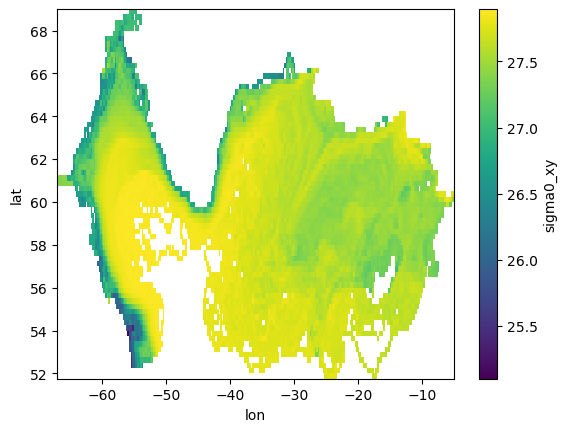

In [10]:
# Plotting the mean potential density along-stream in discrete 2-D longitude-latitude bins:
traj_geo.summary_data.sigma0_xy.plot()

### **Computing Lagrangian Probability Statistics**

The most common 2-dimensional binned statistic in Lagrangian oceanography is the probability density map.

Below we demonstrate how to compute two types of Lagrangian probability density map for our exmaple trajectories circulating around the North Atlantic Subpolar Gyre. The two types of Lagrangian probability are outlined in the excellent review paper by van Sebille et al. (2018):

* 'pos' - What is the probability that any given observation of all water parcel trajectories will be found in a discrete longitude-latitude bin:

$p_{pos} = \frac{N_{pos}(j,i)}{\sum_j \sum_i N_{pos}}$

* 'traj' - What is the probability that any given water parcel will enter a discrete longitude-latitude bin at least once during its trajectory:

$p_{traj} = \frac{N_{traj}(j,i)}{\sum_j \sum_i N_{traj}}$

We will visualise our results with xarray's in-built plotting wrapper of the matplotlib library.

In [11]:
# Compute Lagrangian probability in discrete longitude-latitude bins:
traj_geo.summary_data = xr.Dataset()
traj_geo = (traj_geo
            # Compute volume transport in discrete longitude-latitude bins:
            .compute_probability(bin_res=0.25, # Bin resolution in degrees
                                 prob_type='pos', # Type of Lagrangian probability density.
                                 group=None, # No group-by required.
                                 append=False, # Replace existing summary DataSet.
                                )
            )

# Display the summary data of the TrajFrame:
traj_geo.summary_data

<xarray.Dataset> Size: 139kB
Dimensions:      (lat: 69, lon: 248)
Coordinates:
  * lat          (lat) float64 552B 51.88 52.12 52.38 ... 68.38 68.62 68.88
  * lon          (lon) float64 2kB -66.88 -66.62 -66.38 ... -5.625 -5.375 -5.125
Data variables:
    probability  (lat, lon) float64 137kB nan nan nan nan ... nan nan nan nan

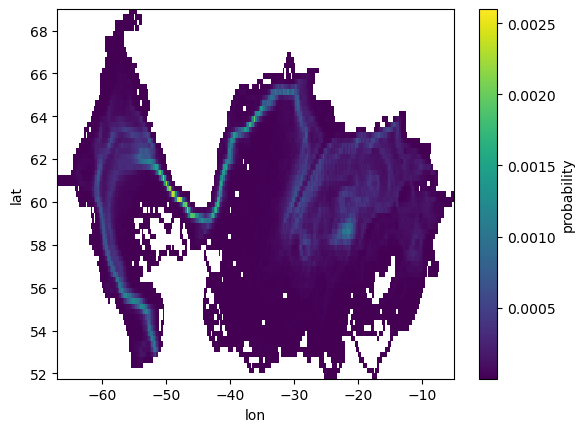

In [12]:
# Plotting the Lagrangian probability in discrete 2-D longitude-latitude bins:
traj_geo.summary_data.probability.plot()

In [17]:
# Compute Lagrangian probability in discrete longitude-latitude bins:
traj_geo.summary_data = xr.Dataset()
traj_geo = (traj_geo
            # Compute volume transport in discrete longitude-latitude bins:
            .compute_probability(bin_res=0.25, # Bin resolution in degrees
                                 prob_type='traj', # Type of Lagrangian probability density
                                 group=None, # No group-by required.
                                 append=False, # Replace existing summary DataSet.
                                )
            )

# Display the summary data of the TrajFrame:
traj_geo.summary_data

<xarray.Dataset> Size: 139kB
Dimensions:      (lat: 69, lon: 248)
Coordinates:
  * lat          (lat) float64 552B 51.88 52.12 52.38 ... 68.38 68.62 68.88
  * lon          (lon) float64 2kB -66.88 -66.62 -66.38 ... -5.625 -5.375 -5.125
Data variables:
    probability  (lat, lon) float64 137kB nan nan nan nan ... nan nan nan nan

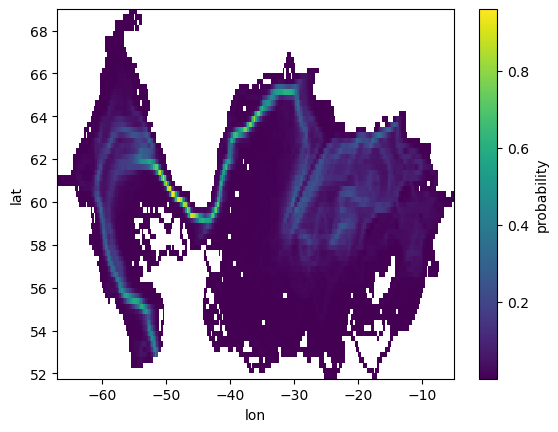

In [18]:
# Plotting the Lagrangian probability in discrete 2-D longitude-latitude bins:
traj_geo.summary_data.probability.plot()
